<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Обучение-модели-на-исходных-данных" data-toc-modified-id="Обучение-модели-на-исходных-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обучение модели на исходных данных</a></span></li><li><span><a href="#Преобразование-исходных-данных-и-повторное-обучение-модели." data-toc-modified-id="Преобразование-исходных-данных-и-повторное-обучение-модели.-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Преобразование исходных данных и повторное обучение модели.</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

In [1]:
# блок для импорта библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## Загрузка данных

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

In [3]:
df.info() # с типами данных всё в порядке.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
df.head(5) # данные выглядят адекватно, кажется, что проводить предобработку не стоит.

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


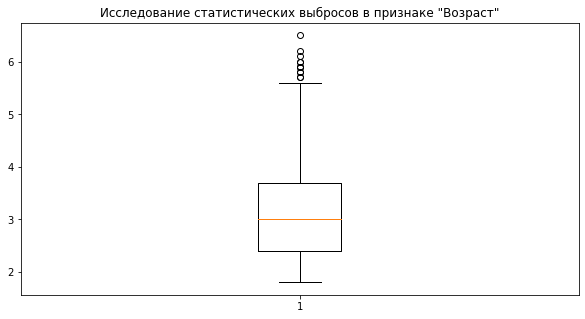

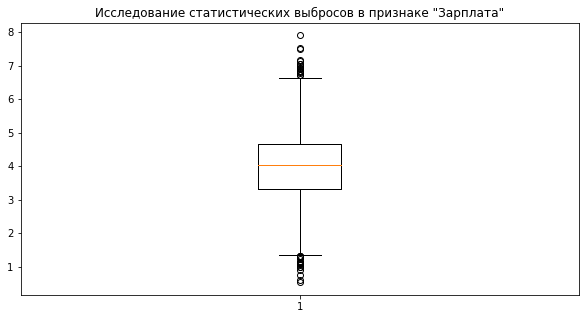

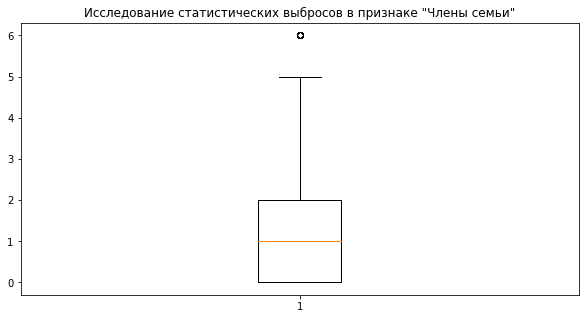

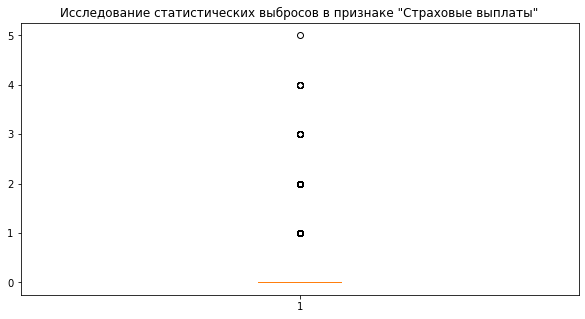

In [5]:
# проверим наличие выбросов в данных:
for f in df.columns:
    max_value = df[f].quantile(0.75)*1.5  # расчитаем верхнюю границу размаха квантилей в "усах" боксплота.
    if len(df[f][df[f] > max_value]) > 0: # если после фильтрации, данные сохраняются, отобразим ситуацию на графике
        plt.figure(figsize=(10, 5)) 
        
        # далее приведём признаки к одному масштабу и визуализируем, для наглядности объёмов стат выбросов.
        if f == 'Зарплата':
            plt.boxplot(df[f]/10000)
            
        elif f == 'Возраст':
            plt.boxplot(df[f]/10)
        
        else:
            plt.boxplot(df[f])
        plt.title(f'Исследование статистических выбросов в признаке "{f}"')
        plt.show()

**В данных присутсвуют выбросы, однако, их кол-во сложно назвать критическим. Поэтому оставим всё как есть и перейдём к следующему этапу проекта.**

## Умножение матриц

**Вопрос:**

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

    a. Изменится. Приведите примеры матриц.
    b. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.


**Ответ:** 
    
    b. Не изменится. 

**Обоснование:** 
    

Действительно, качество линейной регрессии не изменится, если мы умножим признаки на обратимую матрицу. Это можно доказать алгебраически, используя свойства матриц. Давайте это сделаем. 

Пусть у нас есть исходная матрица признаков X и целевой признак y. Мы обучаем модель линейной регрессии и получаем вектор весов w. Вектор весов w можно выразить через матрицу X и вектор y следующим образом: 

$$
w=(X T X) −1 X T y
$$

$$
a = Xw = XEw = XPP^{-1}w = (XP)P^{-1}w = (XP)w'
$$

$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$

$$w' = P^{-1} ((X^T X)^{-1}) (P^T)^{-1} (XP)^T y$$


$$w' = P^{-1} ((X^T X)^{-1}) P^{-T} (XP)^T y$$


$$w' = P^{-1} ((X^T X)^{-1}) P^{-T} (P^TX^T) y$$


$$w' = P^{-1} ((X^T X)^{-1} (P^{-T}P^T )X^T y$$


$$w' = P^{-1} ((X^T X)^{-1} X^T) y$$


$$w' = P^{-1}w$$

## Алгоритм преобразования

**Алгоритм**

Пошагово:
    
    Сгенерируем псевдо-случайную обратимую матрицу P размера n x n, где n — это количество признаков в исходных данных.
    
    Умножим исходную матрицу признаков на получившуюся матрицу P. Это и будет наш новый набор данных.


**Обоснование**

    Мы знаем, что если признаки умножают на обратимую матрицу, то качество линейной регрессии не изменится. Поэтому даже после преобразования мы сможем получить те же предсказания. Однако обратная операция (восстановление исходных данных) будет затруднена без знания матрицы P. Поэтому нам необходимо зафикировать P в переменную.

    Важно учесть, что матрица P должна быть размера n x n, где n — количество признаков. Если количество признаков не совпадает с количеством строк, то умножение на матрицу P не будет возможным. В данном случае у нас есть 4 признака, поэтому это не становится проблемой.

    При использовании этого подхода следует также учесть, что не все матрицы являются обратимыми, поэтому при генерации матрицы P следует проверить её на обратимость. Если матрица не обратима, следует сгенерировать новую, пока не будет получена обратимая матрица.

## Проверка алгоритма

### Обучение модели на исходных данных

In [7]:
# разделим данные на тест и обучение
def data_split(df):
    X_train = df.sample(frac=0.8, random_state=42)
    X_test = df.drop(X_train.index)
    y_train, y_test = X_train['Страховые выплаты'].values, X_test['Страховые выплаты'].values

    X_train, X_test = X_train.drop(columns='Страховые выплаты', axis=1), X_test.drop(columns='Страховые выплаты', axis=1)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

In [8]:
# инциаилизируем класс модели
class LinearRegression:
    """Класс для линейной регрессии"""

    def fit(self, X_train, y_train):
        """
        Обучает модель линейной регрессии.
        
        Параметры:
        X_train : numpy.ndarray
            Матрица признаков обучающей выборки
        y_train : numpy.ndarray
            Вектор целевого признака обучающей выборки
        """
        X = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1) # Добавляем столбец из единиц для коэффициента w0
        y = y_train
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # Вычисляем веса с помощью нормального уравнения линейной регрессии
        
        # Сохраняем параметры модели
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, X_test) -> np.array:
        """
        Предсказывает целевой признак.
        
        Параметры:
        X_test : numpy.ndarray
            Матрица признаков тестовой выборки
            
        Возвращает:
        numpy.ndarray
            Вектор предсказаний модели
        """
        return X_test.dot(self.w) + self.w0

In [9]:
# проверим исходное качество.
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('R2_train_score', round(r2_score(y_train, model.predict(X_train)), 2))
print('R2_test_score', round(r2_score(y_test, predictions), 2))

R2_train_score 0.42
R2_test_score 0.43


### Преобразование исходных данных и повторное обучение модели.

In [12]:
def generate_invertible_matrix(n, seed=42):
    """
    Функция для генерации обратимой матрицы n x n со значениями из нормального распределения.
    
    Параметры:
    n (int): размер матрицы.
    seed (int): зерно для генератора случайных чисел (по умолчанию 42).
    
    Возвращает:
    P (ndarray): обратимая матрица размера n x n.
    """
    # устанавливаем зерно для генератора случайных чисел
    np.random.seed(seed)
    
    # параметры нормального распределения
    mu = 0
    sigma = 0.01
    
    # в цикле генерируем матрицы, пока не получим обратимую
    while True:
        P = np.random.normal(mu, sigma, (n, n))
        # если определитель матрицы не равен нулю, то матрица обратима
        if np.linalg.det(P) != 0:
            return P

# пример использования функции
P = generate_invertible_matrix(4)

In [13]:
features = df.iloc[:, :-1] # отберём все столбцы
df_encoding = pd.DataFrame(np.dot(features, P), columns = features.columns) # создадим дата-фрейм, с признакми
df_encoding['Страховые выплаты'] = df.iloc[:, -1:] # добавим целевой признак

X_train_enc, X_test_enc, y_train_enc, y_test_enc = data_split(df_encoding) # применим фун-цию разделения кода.

In [14]:
# снова инциаилизируем класс и проверим, изменились ли результаты.
model = LinearRegression()
model.fit(X_train_enc, y_train_enc)
predictions_enc = model.predict(X_test_enc)
print('R2_train_score', round(r2_score(y_train_enc, model.predict(X_train_enc)), 2))
print('R2_test_score', round(r2_score(y_test_enc, predictions_enc), 2))

R2_train_score 0.42
R2_test_score 0.43


In [24]:
df_encoding.head(5)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,-232.947912,268.993270,-229.218471,-230.677702,0
1,-178.505558,206.045981,-175.389535,-176.629909,1
2,-98.657526,113.869709,-96.859744,-97.580692,0
3,-195.815152,226.160104,-192.948042,-194.059392,0
4,-122.593411,141.541230,-120.503361,-121.325354,0


**В результате, данные стали скрытыми для пользователей, а качество обучения модели не изменилось.**

Чтобы проеобразовать признаки обратно, нужно домножить преобразовую матрицу на обратную обращённой матрицы.

In [36]:
P_inv = np.linalg.inv(P)
df_original = df_encoding[features.columns].dot(P_inv)
df_original.columns = features.columns

df_original['Пол'] = df_original['Пол'].astype('int')
df_original['Члены семьи'] = df_original['Члены семьи'].astype('int')

df_original.head(5)

,Пол,Возраст,Зарплата,Члены семьи
0,0,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,0,28.0,26100.0,0


In [39]:
df[features.columns].head(5)

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
